In [1]:
import numpy as np
import os
import requests

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

api_url = "https://notify-api.line.me/api/notify"
token = "LYy0yPmrqjMc3rmvdQR2WcbCCVZkmFlf6FZBZGEkpYQ"
headers = {'Authorization':'Bearer '+token}


In [34]:
actions = [
    'fall','stand','walking','lie'
]
data = np.load("./dataset/acldataset/seq_fall-2023-1.npy")
datas = np.load("./dataset/acldataset/seq_stand-2023-1.npy")
datas2 = np.load("./dataset/acldataset/seq_walking-2023-1.npy")
datas3 = np.load("./dataset/acldataset/seq_lie-2023-1.npy")
# datas4 = np.load("./dataset/acldataset/seq_sit-2023-1.npy")
for i in range(2,105):
    data = np.concatenate([
        data,
        np.load(f'./dataset/acldataset/seq_fall-2023-{i}.npy')
    ], axis=0) 
print("1",data.shape) 
# for i in range(2,3):
#     data = np.concatenate([
#         data,
#         np.load(f'./dataset/acldataset/seq_stand-2023-{i}.npy')
#     ], axis=0)
for i in range(2,3):
    data = np.concatenate([
        data,
        np.load(f'./dataset/acldataset/seq_walking-2023-{i}.npy')
    ], axis=0)
print("2",data.shape) 
for i in range(2,3):
    data = np.concatenate([
        data,
        np.load(f'./dataset/acldataset/seq_lie-2023-{i}.npy')
    ], axis=0) 
print("3",data.shape) 
# for i in range(2,48):
#     data = np.concatenate([
#         data,
#         np.load(f'./dataset/acldataset/seq_sit-2023-{i}.npy')
#     ], axis=0) 
# print("4",data.shape) 
        
data = np.concatenate([data,datas,datas2,datas3])
# print(data.shape)

1 (2756, 30, 335)
2 (4406, 30, 335)
3 (5999, 30, 335)


In [11]:
# data = np.load("dataset/seq_fall-2023-1.npy")
# datas = np.load("dataset/seq_stand-2023-1.npy")
# datas2 = np.load("dataset/seq_walking-2023-1.npy")
# datas3 = np.load("dataset/seq_lie-2023-1.npy")


# for i in range(2,60):
#     data = np.concatenate([
#         data,
#         np.load(f'dataset/seq_fall-2023-{i}.npy')
#     ], axis=0)  
# print(data.shape)

# # fall = 1569
# # walking = 2428
# # lie = 5710
# for i in range(2,5):
#     datas3 = np.concatenate([
#         datas3,
#         np.load(f'dataset/seq_lie-2023-{i}.npy')
#     ], axis=0) 

# print(datas.shape)

In [35]:

# print(data[9000:11000,0,-1])
# print(data.shape)
data = np.nan_to_num(data)


x_data = data[:, :, :-1]
labels = data[:, 0, -1]

# print(x_data.shape)
# print(x_data[0,0,:])
# print(labels.shape)
# print(labels[5000:10000])


In [36]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(8102, 4)

In [37]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2,random_state=2022)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(6481, 30, 334) (6481, 4)
(1621, 30, 334) (1621, 4)


In [43]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, test_idx in split.split(x_data,y_data):
    x_train = x_data[train_idx]
    y_train = y_data[train_idx]
    x_val = x_data[test_idx]
    y_val = y_data[test_idx]

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(6481, 30, 334) (6481, 4)
(1621, 30, 334) (1621, 4)


In [39]:
x_train.shape[1:3]

(30, 334)

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,GRU,Dropout

model = Sequential([
    GRU(64,dropout=0.2,activation='relu',input_shape=x_train.shape[1:3]),
    # GRU(32,dropout=0.3),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(64, activation='relu'),
    Dropout(0.1),
    Dense(32, activation='relu'),
    Dropout(0.1),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])
# model = Sequential([
#     GRU(30,dropout=0.2,activation='relu',input_shape=x_train.shape[1:3]),
#     # GRU(32,dropout=0.3),
#     Dense(64, activation='relu'),
#     Dense(32, activation='relu'),
#     Dense(len(actions), activation='softmax')
# ])

model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['acc'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_5 (GRU)                 (None, 64)                76800     
                                                                 
 dense_21 (Dense)            (None, 128)               8320      
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_22 (Dense)            (None, 64)                8256      
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 dense_23 (Dense)            (None, 32)                2080      
                                                                 
 dropout_11 (Dropout)        (None, 32)               

In [45]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=500,
    callbacks=[
        ModelCheckpoint('models/model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
        EarlyStopping(monitor='val_loss', patience=100, verbose=1, mode='auto'),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)
message = {
    "message" : "[낙상감지 알림] : 낙상감지 모델의 학습이 성공적으로 완료되었습니다!"
}

Epoch 1/500
199/203 [============================>.] - ETA: 0s - loss: 0.5515 - acc: 0.7836
Epoch 1: val_loss improved from inf to 0.17044, saving model to models\model.h5
203/203 [==============================] - 3s 11ms/step - loss: 0.5455 - acc: 0.7863 - val_loss: 0.1704 - val_acc: 0.9432 - lr: 0.0010
Epoch 2/500
199/203 [============================>.] - ETA: 0s - loss: 0.1130 - acc: 0.9650
Epoch 2: val_loss improved from 0.17044 to 0.14601, saving model to models\model.h5
203/203 [==============================] - 2s 10ms/step - loss: 0.1126 - acc: 0.9648 - val_loss: 0.1460 - val_acc: 0.9556 - lr: 0.0010
Epoch 3/500
200/203 [============================>.] - ETA: 0s - loss: 0.0472 - acc: 0.9855
Epoch 3: val_loss improved from 0.14601 to 0.04443, saving model to models\model.h5
203/203 [==============================] - 2s 10ms/step - loss: 0.0468 - acc: 0.9857 - val_loss: 0.0444 - val_acc: 0.9870 - lr: 0.0010
Epoch 4/500
201/203 [============================>.] - ETA: 0s - loss: 

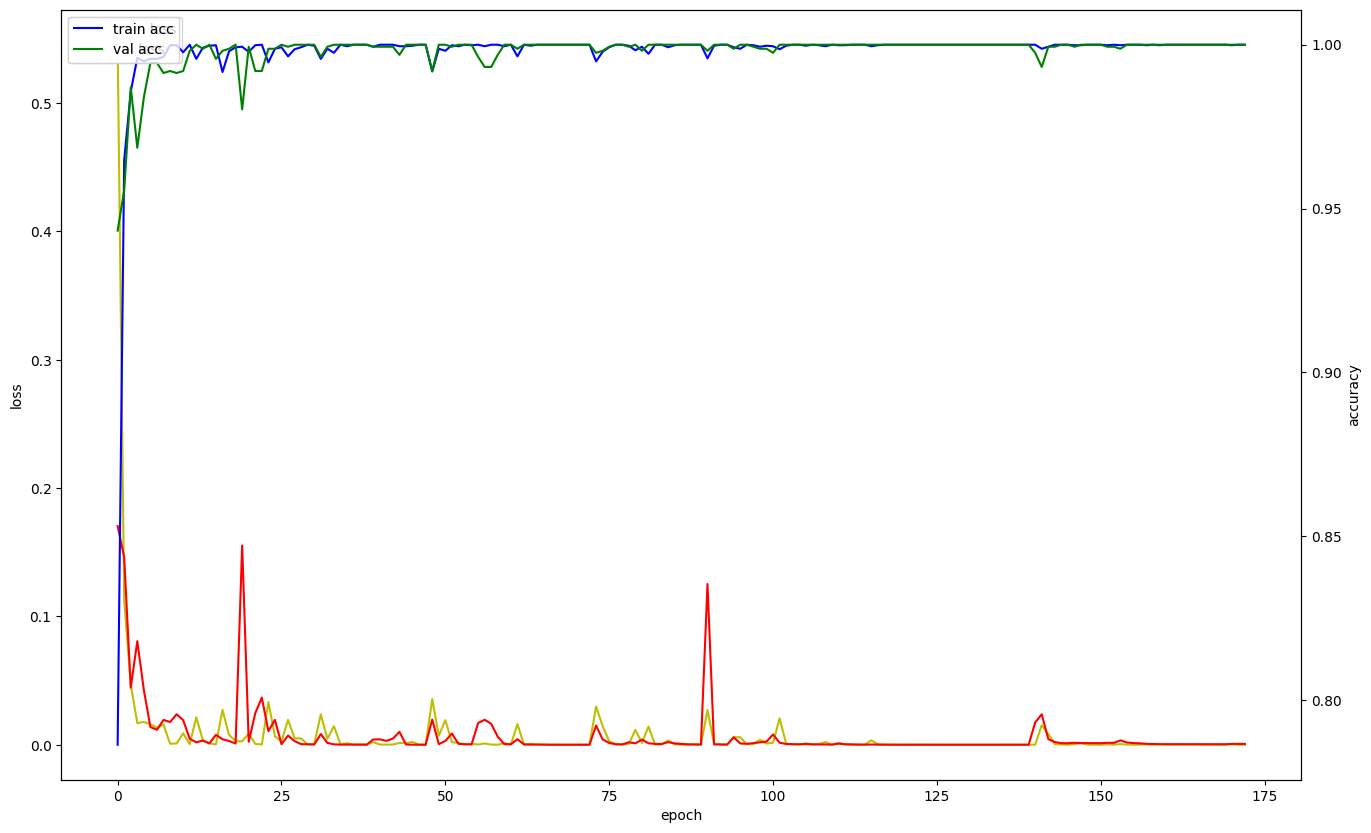

In [46]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [19]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('models/model.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

51/51 [==============================] - 0s 5ms/step


array([[[1070,    0],
        [   0,  551]],

       [[1607,    0],
        [   0,   14]],

       [[1137,    0],
        [   0,  484]],

       [[1049,    0],
        [   0,  572]]], dtype=int64)